In [1]:
import h5py
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import os
from constants import c, h, k
from PIL import Image, ImageOps
from IPython.display import display

To calculate the emissivity in each bin, use the formula

$\Delta I_{\nu}^{\textrm{voxel}\ n,k}  = \tau_{353}^{n,k} \big ( \frac{\nu}{\nu_0} \big )^{\beta^{k}} B_{\nu}(T^{n,k}) 
= \rho_{353}^{k} \Delta E_{\textrm{B-V}}^{n,k} \big ( \frac{\nu}{\nu_0} \big )^{\beta^{k}} B_{\nu}(T^{n,k}) E_{\textrm{B-V}}^{n,k}$

where $k$ is indexing over the pixels in the sky, and $n$ is indexing over the distance bins



In [65]:
#File containing all data (make sure to change this to your directory)
filename="/fs/lustre/cita/molinaca/All_data_3D_temperature_17_dist_bins_nside_128.hdf5"

#Path to store images, change for your directory
image_path ="/fs/lustre/cita/molinaca/Images"

In [3]:
#Function to load the data from the hdf5 file
def load_3D_temperature_data(file):
    data_dict = {}
    with h5py.File(file, "r") as g:    
        data_dict["temperatures"]=g["temperature"][()] # this is (healpix x distance_bin)
        data_dict["distance_slices"] = g["distance_slices"][()]
        data_dict["dEBV"] = g["dEBV_smooth"][()]
        data_dict["rhos"] = g["rhos"][()] 
        data_dict["betas"]= g["betas"][()]
        data_dict["nside"] = g.attrs["nside"]
        data_dict["nr_of_distance_bins"] = g.attrs["nr_of_distance_bins"]
        data_dict["healpix_ordering"] = g.attrs["healpix_ordering"] #nest
        data_dict["run_name"] = g.attrs["original_run_name"]
        g.close()
    return data_dict


In [52]:
#Plotting Functions
def plot_3D_temperature_slice_maps(data_dict):
    
    model_nslices = data_dict["nr_of_distance_bins"]
    model_dist_slices = data_dict["distance_slices"]
    for ds_index in range(model_nslices):                                 
        hp.mollview(Ts[:,ds_index],title=r"$T$ at distance slice "+str(ds_index) +\
                                   " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc",nest=True,min=10,max=25, unit='K')
        #plt.savefig("T_128_"+str(ds_index)+".png")
    
def plot_dEBV(data_dict):
    """ Plot the reddening in each distance bin
    """ 
    dEBV = data_dict["dEBV"]
    model_nslices = data_dict["nr_of_distance_bins"]
    model_dist_slices = data_dict["distance_slices"]
    for ds_index in range(model_nslices):
        hp.mollview(dEBV[ds_index], title="Differential E(B-V) at distance slice "+str(ds_index) +\
                     " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc", nest=True, max=1)
        
def plot_map(data_dict, map, min_map, max_map, title_map, unit_map):
    """ 
    Function to plot any map as long as it has the form distance bin x pixel

    Parameters:
    data_dict: dictionary containing the data
    map: map to be plotted with shape (distance_bin x pixel) so if it has freq have to select freq before
    min_map: float, minimum value of the map
    max_map: float, maximum value of the map
    title: string, title of the plot
    unit_map: string, unit of the map

    Output:
    Plots the map at each distance slice
    """ 
    model_nslices = data_dict["nr_of_distance_bins"]
    model_dist_slices = data_dict["distance_slices"]

    for ds_index in range(model_nslices):
        
        hp.mollview(map[ds_index],title=f"{title_map} at distance slice "+str(ds_index) +\
                                        " at "+'{:.2f}'.format(model_dist_slices[ds_index])+" kpc",nest=True,min=min_map, max=max_map, unit=unit_map)
    
def plot_map_region(map, distance, longitude, latitude, x, y, min_map, max_map, title_map, unit_map):
    hp.gnomview(map[distance], rot=(longitude,latitude), title=title_map, nest=True, xsize=x, ysize=y, min=min_map, max=max_map, unit=unit_map, notext=True)

In [59]:
#Other functions
def increase_temp_res(data_dict, nside_new):
    '''
    Function used to increase the resolution of the temperature map

    Parameters:
    data_dict: dictionary containing the data
    nside_new: new nside to be used

    Output:
    Ts_new: new temperature map with the new nside
    '''
    Ts = data_dict["temperatures"]
    model_nslices = data_dict["nr_of_distance_bins"]

    Ts_new = np.zeros((model_nslices, hp.nside2npix(nside_new))) #Create new temperature with the new nside, note that have to switch axis because of the way ud_grade works
    
    #Increase resolution at each distance slice
    for ds_index in range(model_nslices):
        Ts_new[ds_index] = hp.ud_grade(Ts[:,ds_index], nside_out=nside_new, order_in='NESTED', order_out='NESTED') 

    return Ts_new

#Planck function to get temperature emission
def Planck (nu, Tmap):
    '''
    Function to calculate the Planck function at a frequency nu for a given temperature map

    Parameters:
    nu: frequency in Hz
    Tmap: temperature map in Kelvin
    h: planck constant from constants.py
    c: speed of light from constants.py
    k: boltzmann constant from constants.py
    x_d: variable used to simplify planck function

    Output:
    B = 2*h*nu**3/c**2/(np.exp(x_d)-1) : planck function in units W/m^2/Hz/sr
    '''
    x_d = h*nu/(k*Tmap)
    return 2*h*nu**3/c**2/(np.exp(x_d)-1)

#Wien's Law 
def WiensLaw(T):
    '''
    Function that uses Wien's law to calculate the maximum frequency of a black body radiation curve at a given temperature

    Parameters:
    T: temperature in Kelvin
    h: planck constant from constants.py
    k: boltzmann constant from constants.py

    Output:
    nu_max: maximum frequency in Hz
    '''
    nu_max = 2.824*k*T/h
    return nu_max

def multiply_dEBVandB(data_dict, dEBVmap, Bmap, frequency):
    model_nslices = data_dict["nr_of_distance_bins"]

    dens_temp = np.zeros((len(frequency), dEBV.shape[0], dEBV.shape[1]))

    for f_index in range(len(frequency)):
    
        for ds_index in range(model_nslices):
            #Perform multiplication
            dens_temp[f_index, ds_index] = dEBVmap[ds_index]*Bmap[f_index, ds_index]
    
    return dens_temp
        
def normalize_dEBVandB(data_dict, dens_temp, frequency):
    model_nslices = data_dict["nr_of_distance_bins"]
    nfreq = len(frequency)

    dens_temp_norm = np.zeros((nfreq, dens_temp.shape[1], dens_temp.shape[2]))

    max_distance = np.zeros(model_nslices)
    max_freq = np.zeros(nfreq)

    for f_index in range(nfreq):
        for ds_index in range(model_nslices):
            max_distance[ds_index] = np.max(dens_temp[f_index, ds_index])

        max_freq[f_index] = np.max(max_distance)

    max_overall = np.max(max_freq)

    #Normalize
    for f_index in range(nfreq):
        for ds_index in range(model_nslices):
            dens_temp_norm[f_index, ds_index] = dens_temp[f_index, ds_index]/max_overall

    return dens_temp_norm

def get_RGB(dens_temp):
    nslices = dens_temp.shape[1]
    pixels = dens_temp.shape[2]
    max_pixel = 255
    

    R_array = np.zeros((nslices, pixels))
    G_array = np.zeros((nslices, pixels))
    B_array = np.zeros((nslices, pixels))

    for ds_index in range(nslices):
        R_array[ds_index] = dens_temp[0, ds_index]
        G_array[ds_index] = dens_temp[1, ds_index]
        B_array[ds_index] = dens_temp[2, ds_index]

    #Make it so that its in between 0 and 255
    R = (R_array*255).astype(np.uint8)
    G = (G_array*255).astype(np.uint8)
    B = (B_array*255).astype(np.uint8)

    return R, G, B
    
def get_region_image(R, G, B, dist, longitude, latitude, x, y, scale=False):

    #Use hp.gnomview to get a 2d array of the region that will be used to create the image

    R_2darray = hp.gnomview(R[dist], rot=(longitude,latitude), nest=True, xsize=x, ysize=y, return_projected_map=True)
    plt.close()
    G_2darray = hp.gnomview(G[dist], rot=(longitude,latitude), nest=True, xsize=x, ysize=y, return_projected_map=True)
    plt.close()
    B_2darray = hp.gnomview(B[dist], rot=(longitude,latitude), nest=True, xsize=x, ysize=y, return_projected_map=True)
    plt.close()

    R_array = np.array(R_2darray)
    G_array = np.array(G_2darray)
    B_array = np.array(B_2darray)

    if scale==True:
        max_pixel = 255
        max_intensity = np.max([np.max(R_array), np.max(G_array), np.max(B_array)])
        scale_factor = max_pixel/max_intensity

        R_array = R_array*scale_factor
        G_array = G_array*scale_factor
        B_array = B_array*scale_factor

    #gnomview returns inverted array, so have to flip it to get correct image
    R_flipped = np.flipud(R_array)
    G_flipped = np.flipud(G_array)
    B_flipped = np.flipud(B_array)

    R_uint = R_flipped.astype(np.uint8)
    G_uint = G_flipped.astype(np.uint8)
    B_uint = B_flipped.astype(np.uint8)

    R_img = Image.fromarray(R_uint)
    G_img = Image.fromarray(G_uint)
    B_img = Image.fromarray(B_uint)

    RGB_img = Image.merge("RGB", (R_img, G_img, B_img))

    return R_uint, G_uint, B_uint, RGB_img


## Creating map of density x temperature
This part of the code contains the steps required to create a density x temperature map of the sky. It includes increasing the resolution of the temperature map, converting that to temperature emissivity and multiplying that by dEBV. 

### Create new temperature map with resolution that matches dEBV map
The temperature map has an nside of 128, but dEBV has an nside of 1024, in order to multiply these the resolution of the temperature map has to be increased. 

In [6]:
#Load all maps
data_dict=load_3D_temperature_data(filename)

In [38]:
#Define  Ts, dEBV and increase resolution of Ts

#Define dEBV and clip it due to negative values
dEBV = data_dict["dEBV"]
dEBV = np.clip(dEBV, 0, None)

##Get nside of the temperature and density maps
Ts = data_dict["temperatures"] #Original temperature map, defining for ease of use

print("Temperature resolution:", hp.get_nside(Ts[:,0]))
print("E(B-V) resolution:", hp.get_nside(dEBV[0]))

##Increase resolution of temperature map to 1024
Ts_new = increase_temp_res(data_dict, 1024)
                                  
#Some checks to make sure everything is working
print("New temperature resolution:", hp.get_nside(Ts_new[0]))

print("Shape of original temperature map:", Ts.shape)
print("Shape of new temperature map:", Ts_new.shape)

print("Original temperature array:\n", Ts)
print("New temperature array:\n", Ts_new)


Temperature resolution: 128
E(B-V) resolution: 1024
New temperature resolution: 1024
Shape of original temperature map: (196608, 17)
Shape of new temperature map: (17, 12582912)
Original temperature array:
 [[18.800053  16.870003  15.337718  ...  5.        14.146356  26.819225 ]
 [18.789234  19.42068   18.598013  ... 19.548403  19.369473  16.124052 ]
 [19.040045  18.37719   22.935205  ... 18.276548   7.277836  18.685047 ]
 ...
 [26.139109  17.511135  25.047724  ... 24.625113   6.7835207 10.880443 ]
 [18.800133  18.800201  18.799892  ... 18.799957  18.799862  18.799978 ]
 [18.80004   18.79939   18.80011   ... 18.800066  18.799824  18.799965 ]]
New temperature array:
 [[18.80005264 18.80005264 18.80005264 ... 18.80003929 18.80003929
  18.80003929]
 [16.87000275 16.87000275 16.87000275 ... 18.79939079 18.79939079
  18.79939079]
 [15.33771801 15.33771801 15.33771801 ... 18.80010986 18.80010986
  18.80010986]
 ...
 [ 5.          5.          5.         ... 18.80006599 18.80006599
  18.800065

In [36]:
#Plotting temperature map with new resolution
#plot_map(data_dict, Ts_new, 10, 25, 'New Temperature Map', 'K')

### Get temperature emission and frequencies
Use Wien's law for 3 given temperatures (that will correspond to each color channel) to get the maximum frequency for each. Use this with the planck function to create temperature emissivity maps at each frequency. 

In [27]:
#Calculate frequencies
freq1 = WiensLaw(10) 
freq2 = WiensLaw(18.8)
freq3 = WiensLaw(30)

frequency = [freq1, freq2, freq3] #make array of frequencies in Hz, will be used in calculations
freq_ghz = [freq1*1e-9, freq2*1e-9, freq3*1e-9] #Change to GHz for printing only
print(freq_ghz)

[588.4261240427707, 1106.241113200409, 1765.2783721283122]


In [28]:
##Get new maps by taking the planck function at each frequency    
planck_maps = np.zeros((len(frequency), Ts_new.shape[0], Ts_new.shape[1])) #Create array to store the planck maps
for i in range(len(frequency)):
    planck_maps[i] = Planck(frequency[i], Ts_new)


In [33]:
#Plotting planck functions
min_planck = [1e-17, 4e-16, 3e-21] #Get minimum for each for better visibility
max_planck = 2e-15 #They all have the same maximum
unit_planck = r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$'

#plot_map(data_dict, planck_maps[0], min_planck[0], max_planck, f'$B$ for {int(freq_ghz[0])} GHz', unit_planck)
#plot_map(data_dict, planck_maps[1], min_planck[1], max_planck, f'$B$ for {int(freq_ghz[1])} GHz', unit_planck)
#plot_map(data_dict, planck_maps[2], min_planck[2], max_planck, f'$B$ for {int(freq_ghz[2])} GHz', unit_planck)

### Multiply dEBV and B maps

In [24]:
dens_temp = multiply_dEBVandB(data_dict, dEBV, planck_maps, frequency)
dens_temp_norm = normalize_dEBVandB(data_dict, dens_temp, frequency)

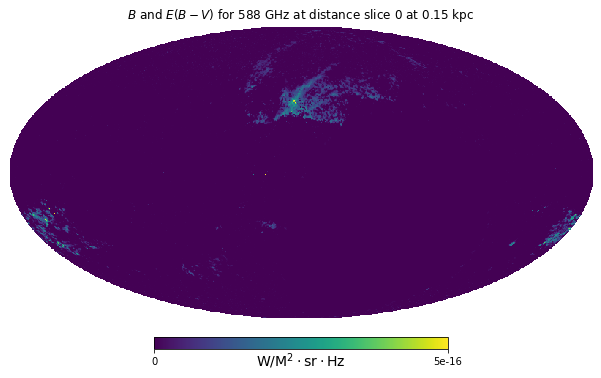

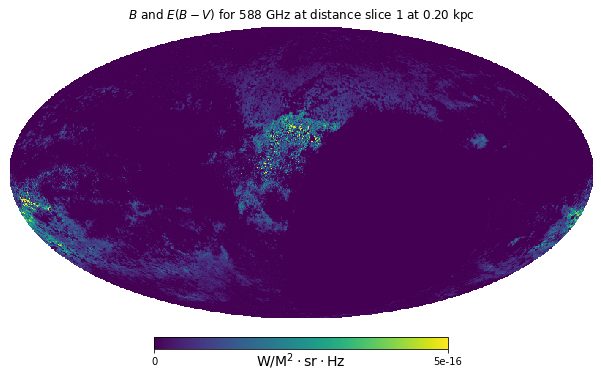

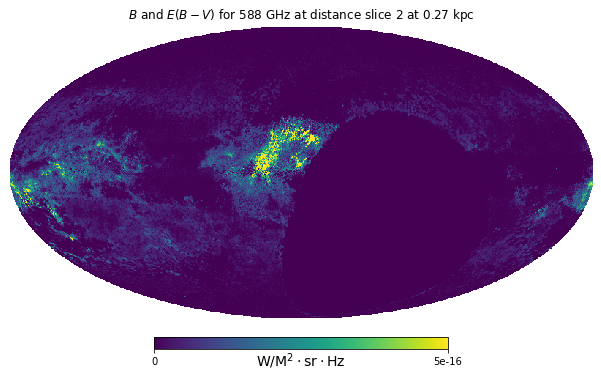

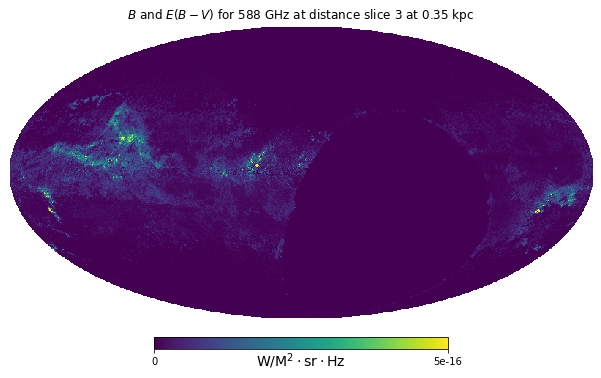

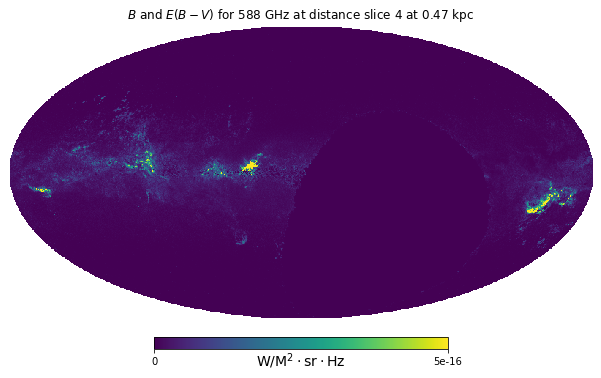

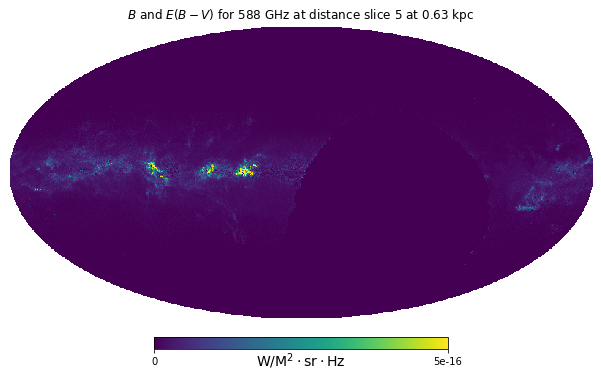

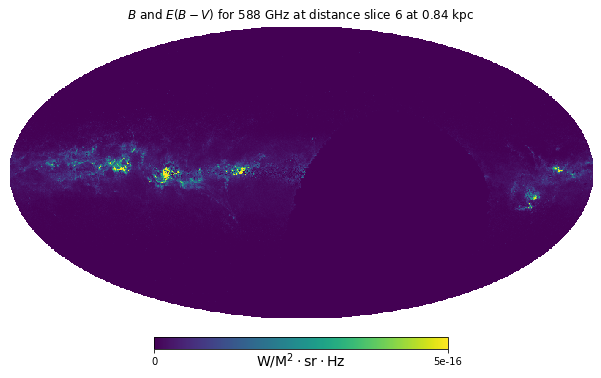

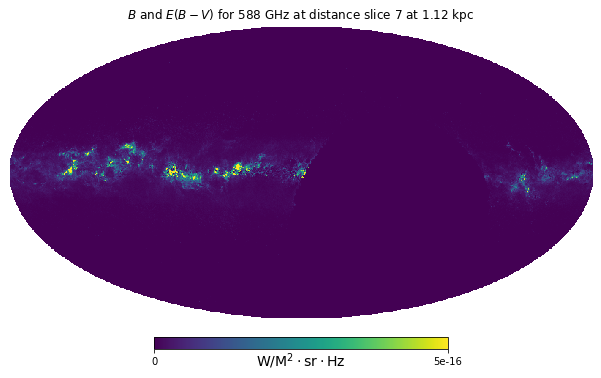

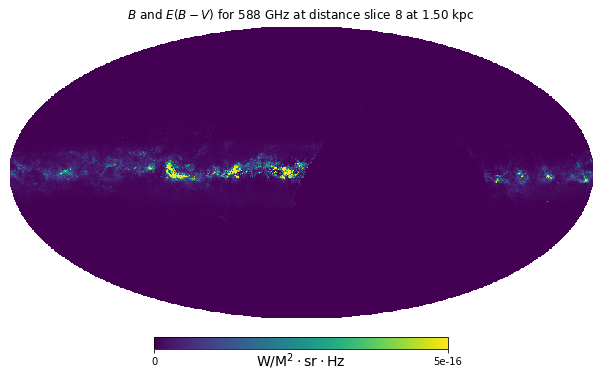

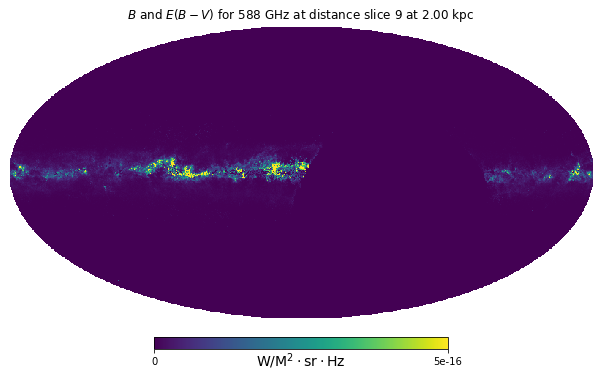

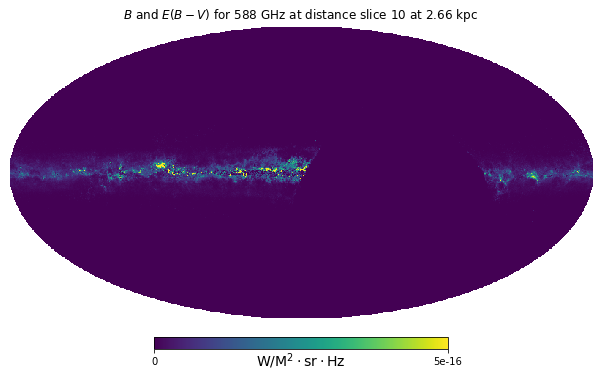

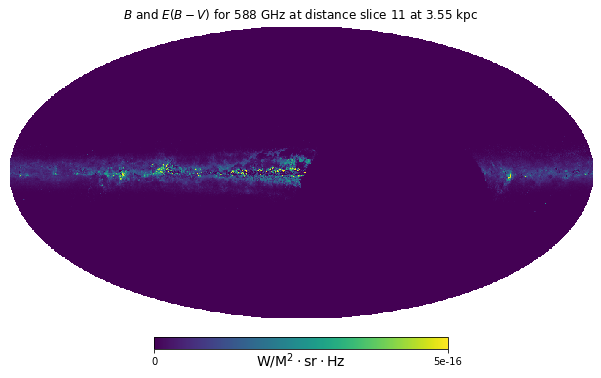

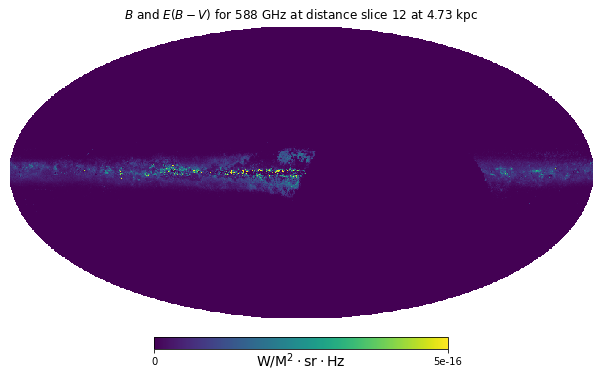

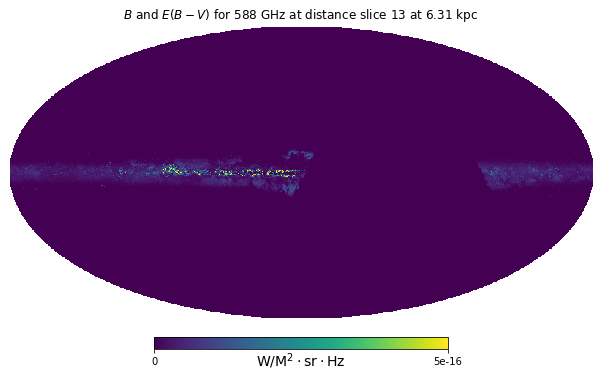

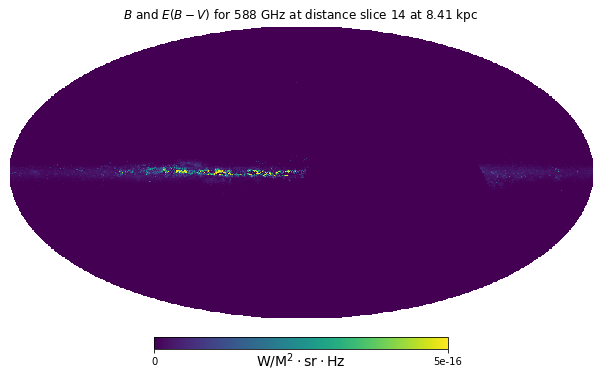

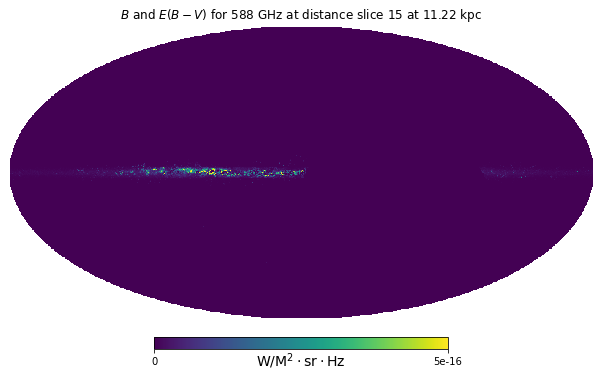

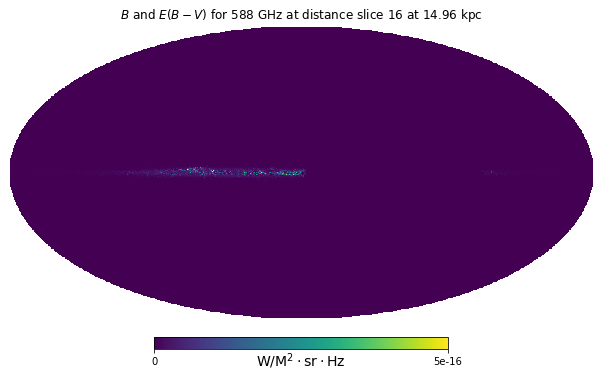

In [26]:
#Plotting density times temperature maps
min_dxT = 0 #all have the same minimum
max_dxT = [5e-16, 7e-16, 6e-16]
unit_dxT = r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$' #same units as planck function

#plot_map(data_dict, dens_temp[0], min_dxT, max_dxT[0], f"$B$ and $E(B-V)$ for {int(freq_ghz[0])} GHz", unit_dxT)
#plot_map(data_dict, dens_temp[1], min_dxT, max_dxT[1], f"$B$ and $E(B-V)$ for {int(freq_ghz[1])} GHz", unit_dxT)
#plot_map(data_dict, dens_temp[2], min_dxT, max_dxT[2], f"$B$ and $E(B-V)$ for {int(freq_ghz[2])} GHz", unit_dxT)



In [40]:
#How you would plot normalized densxtemp map but haven't actually seen what the max should be

#plot_map(data_dict, dens_temp_norm[0], 0, 1, f"Normalized $B$ and $E(B-V)$ for {int(freq_ghz[0])} GHz", None)
#plot_map(data_dict, dens_temp_norm[1], 0, 1, f"Normalized $B$ and $E(B-V)$ for {int(freq_ghz[1])} GHz", None)
#plot_map(data_dict, dens_temp_norm[2], 0, 1, f"Normalized $B$ and $E(B-V)$ for {int(freq_ghz[2])} GHz", None)

In [22]:
#Calculate difference of dEBV and new map with temperature
dEBV_diff = {}

for f_index in range(3):
    dEBV_diff[f_index] = np.zeros((model_nslices, len(planck_maps[0, 0])))
    for ds_index in range(model_nslices):
        dEBV_diff[f_index, ds_index] = dens_temp_norm[f_index, ds_index] - dEBV[ds_index]

# for ds_index in range(model_nslices):
#     hp.mollview(dEBV_diff[0, ds_index], title=r"$B$ and $E(B-V)$ for 588 GHz at distance slice 0",nest=True, min = -1, max = 1, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$')

## Create RGB Images
This code creates RGB images of Cepheus, Orion A & B and the whole sky. It also creates panels

In [63]:
#Set up global RGB arrays that will be used in other cells
R, G, B = get_RGB(dens_temp_norm)



### Looking at the Cepheus Local Molecular Cloud

In [51]:
#Pick section of LMC Cepheus

d_ceph = 3 #is at distance slice 3
l_ceph = 112.1
b_ceph = 15.9

x_ceph = 2000
y_ceph = 2000
min_ceph = 0
max_ceph = 0.09

#for fs_index in range(len(frequency)):
#    plot_map_region(dens_temp_norm[fs_index, d_ceph], l_ceph, b_ceph, x_ceph, y_ceph, min_ceph, max_ceph, f"Normalized $B$ and $E(B-V)$ of the Cepheus Molecular Cloud at {int(freq_ghz[fs_index])} GHz", None)

In [68]:
cepheus_path = os.path.join(image_path, "Cepheus")

R_ceph, G_ceph, B_ceph, RGB_ceph = get_region_image(R, G, B, d_ceph, l_ceph, b_ceph, x_ceph, y_ceph, scale=True)
RGB_ceph.save(cepheus_path + "/ceph_rgb_scaled.png")

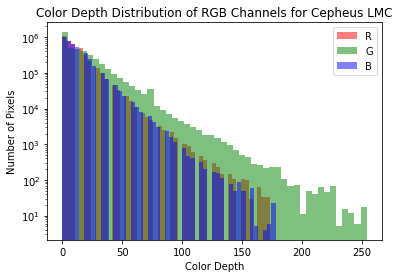

In [71]:
#Looking at histogram and gnomview of color depth of each channel

#Plotting the histograms of flattened RGB arrays
plt.hist(R_ceph.flatten(), bins=50, color='red', alpha=0.5, label='R')
plt.hist(G_ceph.flatten(), bins=50, color='green', alpha=0.5, label='G')
plt.hist(B_ceph.flatten(), bins=50, color='blue', alpha=0.5, label='B')
plt.yscale('log') 
plt.xlabel('Color Depth')
plt.ylabel('Number of Pixels')
plt.title('Color Depth Distribution of RGB Channels for Cepheus LMC')
plt.legend(loc='upper right')
plt.savefig(cepheus_path + "/ceph_rgb_hist_scaled.png") 
plt.show()

#Plotting the color depth of each channel but with gnomview
# plot_map_region(R, d_ceph, l_ceph, b_ceph, x_ceph, y_ceph, min_ceph, None, 'Cepheus LMC in R Color Channel', r'Color Depth')
# plt.savefig(cepheus_path + "/ceph_R.png")
# plot_map_region(G, d_ceph, l_ceph, b_ceph, x_ceph, y_ceph, min_ceph, None, 'Cepheus LMC in G Color Channel', r'Color Depth')
# plt.savefig(cepheus_path + "/ceph_G.png")
# plot_map_region(B, d_ceph, l_ceph, b_ceph, x_ceph, y_ceph, min_ceph, None, 'Cepheus LMC in B Color Channel', r'Color Depth')
# plt.savefig(cepheus_path + "/ceph_B.png")


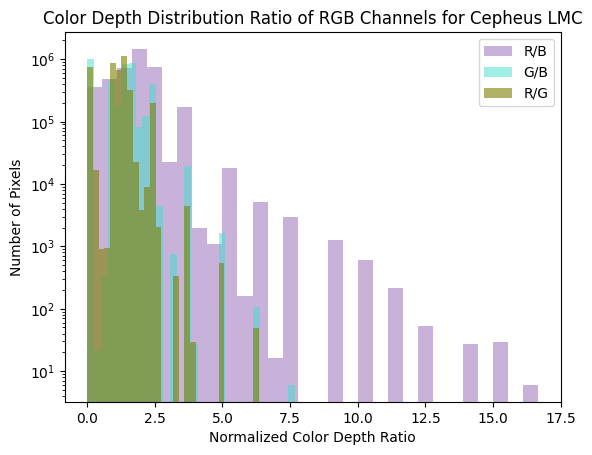

In [176]:
#Get the ratio of the color channels and make histograms

ceph_ratio_RB = np.divide(R_ceph.flatten(), B_ceph.flatten(), where=B_ceph.flatten()!=0) #Last part is so that there is no division by zero
plt.hist(ceph_ratio_RB, bins=30, color='indigo',alpha=0.3, label='R/B') #Different alpha values to make contrast better

ceph_ratio_GB = np.divide(G_ceph.flatten(), B_ceph.flatten(), where=B_ceph.flatten()!=0)
plt.hist(ceph_ratio_GB, bins=30, color='turquoise', alpha=0.5, label='G/B')

ceph_ratio_RG = np.divide(R_ceph.flatten(), G_ceph.flatten(), where=G_ceph.flatten()!=0)
plt.hist(ceph_ratio_RG, bins=30, color='olive', alpha=0.6, label='R/G')

plt.yscale('log')
plt.xlabel('Normalized Color Depth Ratio')
plt.ylabel('Number of Pixels')
plt.title('Color Depth Distribution Ratio of RGB Channels for Cepheus LMC')
plt.legend()
plt.savefig("/fs/lustre/cita/molinaca/Images/Cepheus/ceph_rgb_hist_ratios.png")
plt.show()


In [69]:
#Save images needed for the panel

hp.gnomview(Ts[:,d_ceph], rot=[l_ceph, b_ceph], xsize=2000, ysize=2000,title='$T$ of Cepheus LMC with nside 32', nest=True,min=10,max=25, unit='K', notext=True)
plt.savefig("/fs/lustre/cita/molinaca/Images/Cepheus/ceph_T_og.png")
plt.close()
hp.gnomview(Ts_new[d_ceph], rot=[l_ceph, b_ceph], xsize=2000, ysize=2000,title='$T$ of Cepheus LMC with nside 1024', nest=True,min=10,max=25, unit='K', notext=True)
plt.savefig("/fs/lustre/cita/molinaca/Images/Cepheus/ceph_T_new.png")
plt.close()
hp.gnomview(dEBV[d_ceph], rot=[l_ceph, b_ceph], xsize=2000, ysize=2000,title='$E(B-V)$ of Cepheus LMC', nest=True, max=1, notext=True)
plt.savefig("/fs/lustre/cita/molinaca/Images/Cepheus/ceph_dEBV.png")
plt.close()


for f_index in range(3):
    
    hp.gnomview(planck_maps[f_index, d_ceph], rot=[l_ceph, b_ceph], xsize=2000, ysize=2000,title=f'Temperature Emission $B$ of Cepheus LMC at {int(freq_ghz[f_index])} GHz', nest=True,min=1e-17, max=2e-15, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$', notext=True)
    plt.savefig(f"/fs/lustre/cita/molinaca/Images/Cepheus/ceph_planck_{int(freq_ghz[f_index])}.png")
    plt.close()
    hp.gnomview(dens_temp_norm[f_index,d_ceph], rot=[l_ceph, b_ceph], xsize=2000, ysize=2000,title=f'Normalized $B$ and $E(B-V)$ of Cepheus LMC at {int(freq_ghz[f_index])} GHz', nest=True, min = 0, max = 0.2, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$', notext=True)
    plt.savefig(f"/fs/lustre/cita/molinaca/Images/Cepheus/ceph_dxT_norm_{int(freq_ghz[f_index])}.png")
    plt.close()


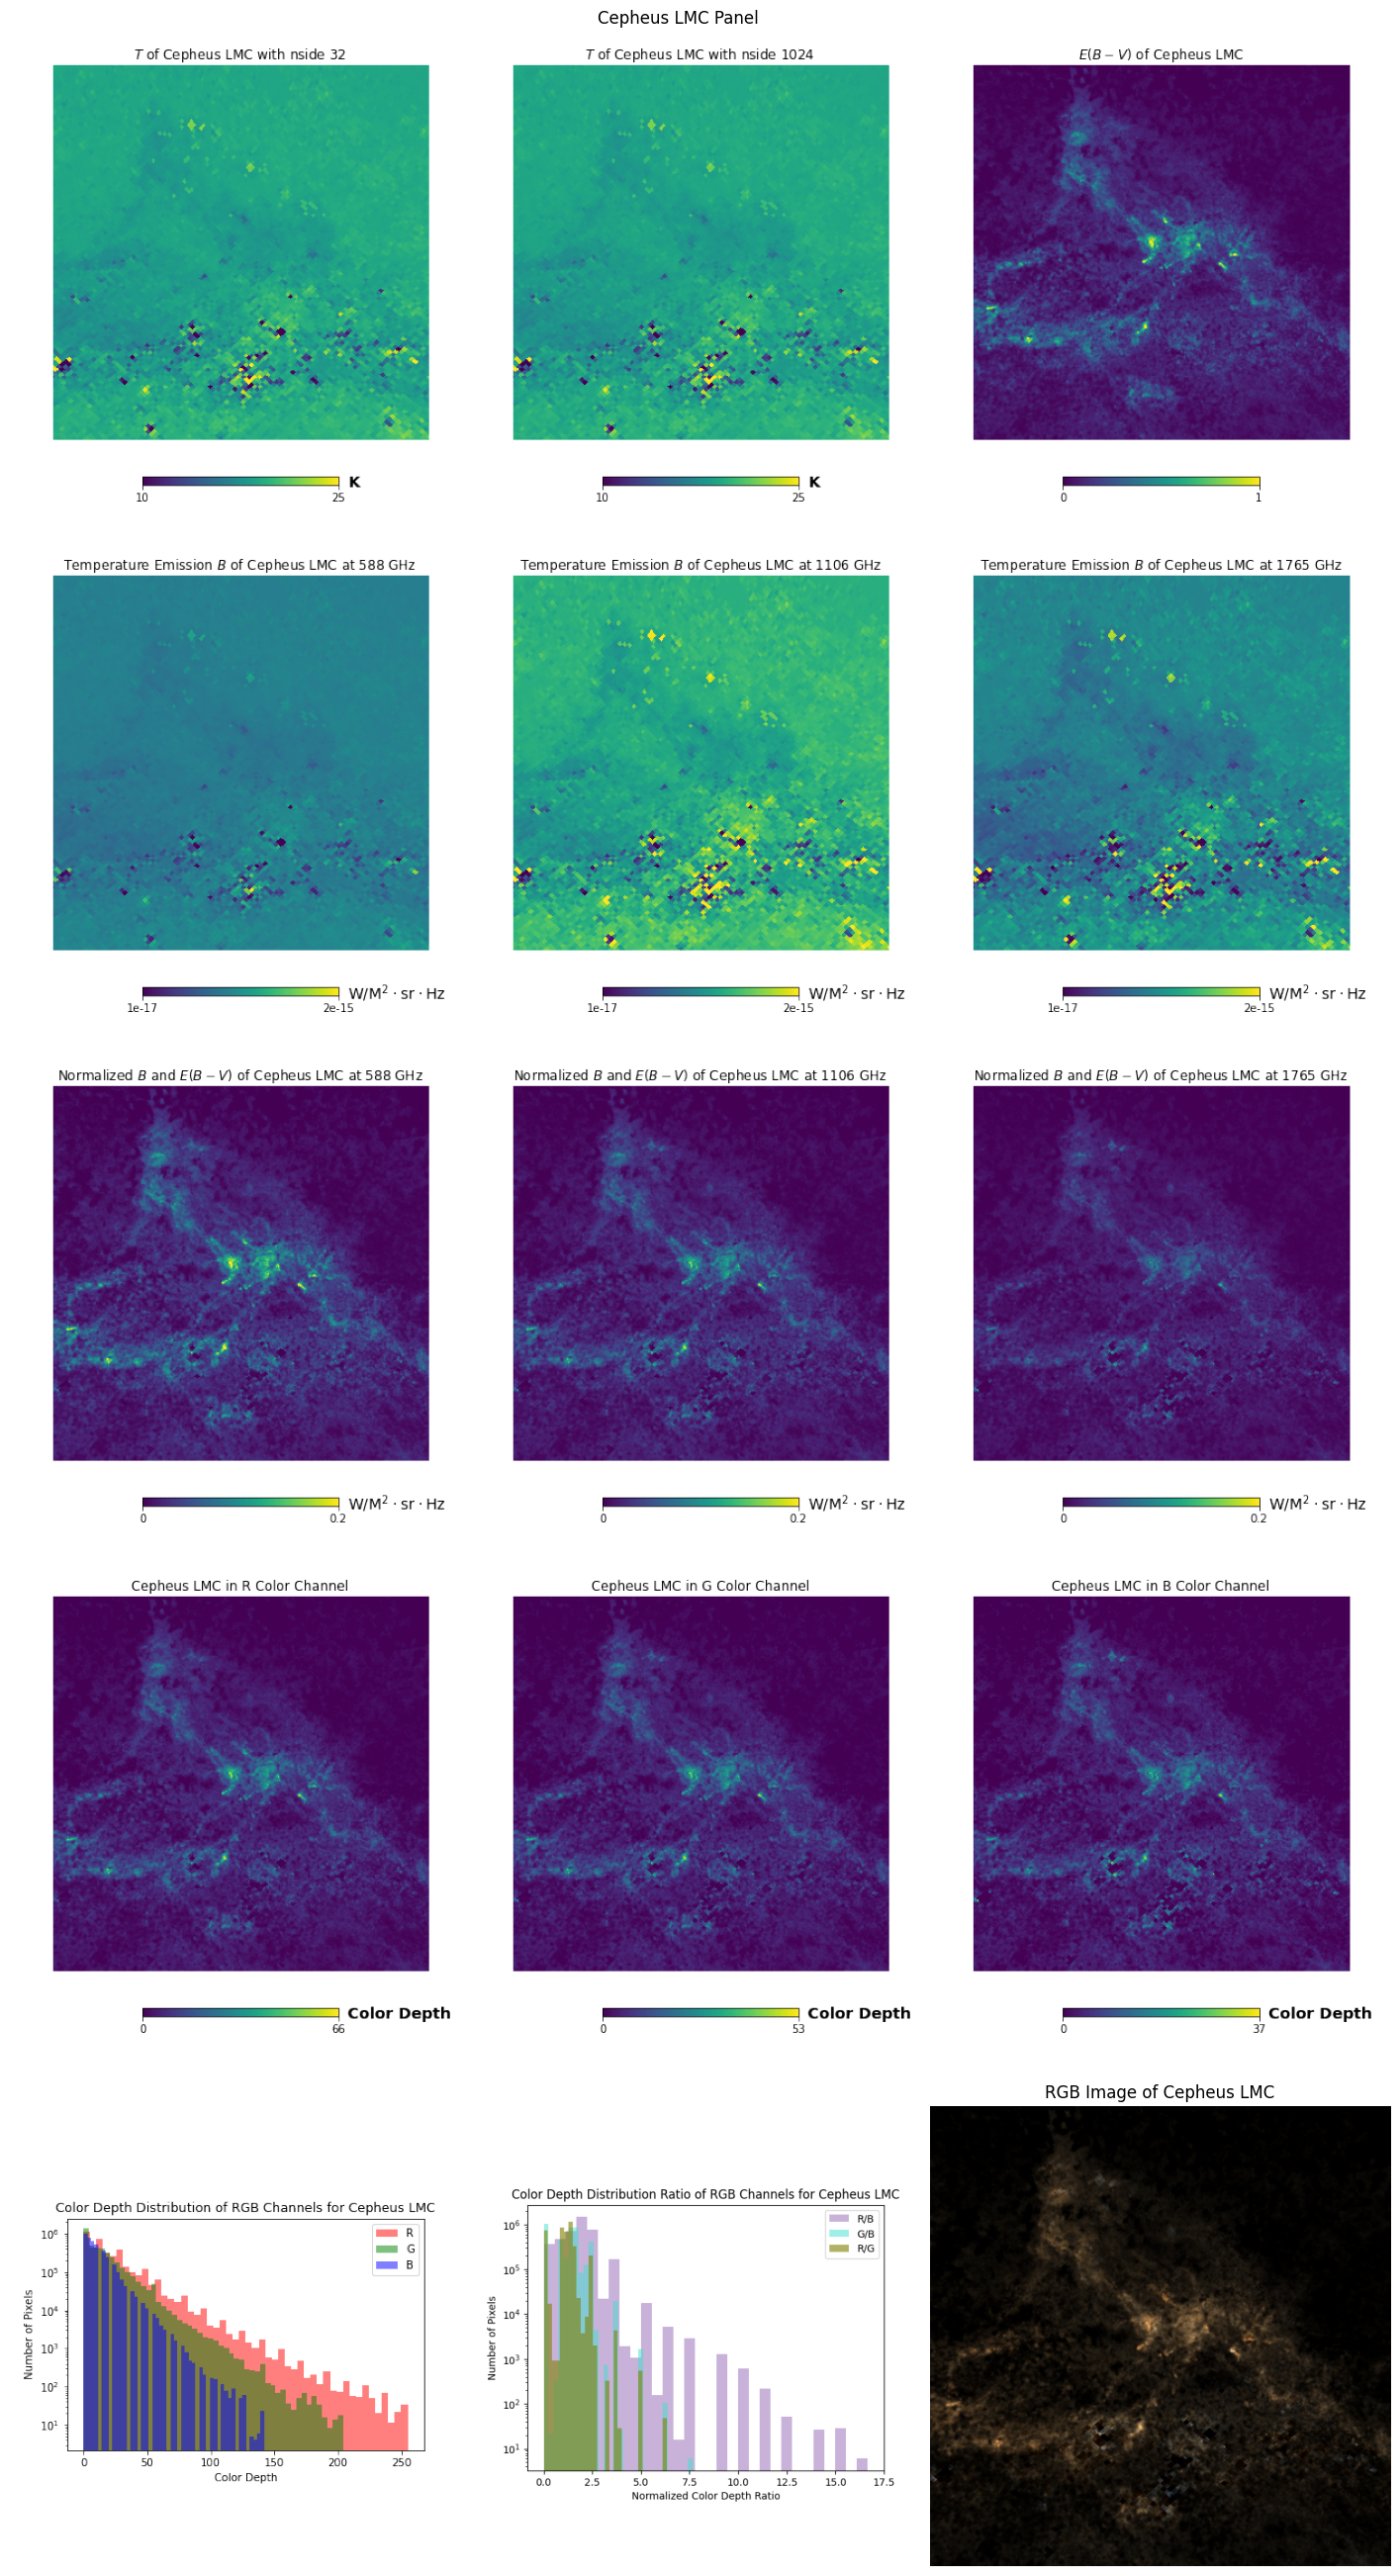

In [177]:
#Creating panel of images of Cepheus LMC
ceph_panel = plt.figure(figsize=(18, 30))
gs = gridspec.GridSpec(5, 3, ceph_panel)

#Get image paths and names to not repeat code
ceph_img_path = "/fs/lustre/cita/molinaca/Images/Cepheus/ceph_" #image path is the same for all of them
ceph_img_names = ['T_og', 'T_new', 'dEBV', 'planck_588', 'planck_1106', 'planck_1765', 'dxT_norm_588', 'dxT_norm_1106', 'dxT_norm_1765', 'R', 'G', 'B', 'rgb_hist_scaled', 'rgb_hist_ratios', 'rgb_scaled'] #array of names

for i in range(5):  # Assuming 5 rows
    for j in range(3):  # Assuming 3 columns
        ceph_panel.add_subplot(gs[i, j]) #add subplots
        img_index = i * 3 + j  #Can avoid iterating over the image index too
        img = Image.open(ceph_img_path + ceph_img_names[img_index] + '.png') #Have to string them all together

        if img_index < len(ceph_img_names): #Making a check 
            plt.imshow(img)
        plt.axis('off')  

        if ceph_img_names[img_index] == 'rgb_scaled': #This image has no title so have to manually add title
            plt.title('RGB Image of Cepheus LMC')

plt.subplots_adjust(wspace=0, hspace=0, top=0.97)
plt.suptitle('Cepheus LMC Panel')

plt.savefig('/fs/lustre/cita/molinaca/Images/Cepheus/ceph_panel.png', facecolor='white', edgecolor='none')

plt.show()

### Looking at Orion A and B Molecular Clouds

In [135]:
#Just looking at what Orion A and B look like with density x temperature map at diff frequencies
l_orionB = 205.5
b_orionB = -14
d_orionB = 4 #At distance slice 4

#Plotting to see what it looks like at each frequency
#hp.gnomview(dens_temp_norm[0,d_orionB], rot=[l_orionB, b_orionB], title='$E(B-V)$ at 588 GHz', xsize=1500, ysize=1500, nest=True,min = 0, max = 0.3, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$', notext=True)
#hp.gnomview(dens_temp_norm[1,d_orionB], rot=[l_orionB, b_orionB], title='$E(B-V)$ at 1106 GHz', xsize=1500, ysize=1500, nest=True,min = 0, max = 0.3, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$', notext=True)
#hp.gnomview(dens_temp_norm[2,d_orionB], rot=[l_orionB, b_orionB], title='$E(B-V)$ at 1765 GHz', xsize=1500, ysize=1500, nest=True,min = 0, max = 0.3, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$', notext=True)

In [178]:
#Creating RGB image for Orion A and B

R_orion = hp.gnomview(R_array[d_orionB], rot=[l_orionB, b_orionB], xsize=1500, ysize=1500, nest=True, return_projected_map=True)
plt.close()
G_orion = hp.gnomview(G_array[d_orionB], rot=[l_orionB, b_orionB], xsize=1500, ysize=1500, nest=True, return_projected_map=True)
plt.close()
B_orion = hp.gnomview(B_array[d_orionB], rot=[l_orionB, b_orionB], xsize=1500, ysize=1500, nest=True, return_projected_map=True)
plt.close()

R_orion = (np.array(R_orion)).astype(np.uint8) #Have to make it as form array and then uint8 (for an image)
G_orion = (np.array(G_orion)).astype(np.uint8)
B_orion = (np.array(B_orion)).astype(np.uint8)

#----Method = Adjusting brightness by using scaling factor----#
max_intensity_orion = max(np.max(R_orion), np.max(G_orion), np.max(B_orion))
scaling_factor_orion = 255.0 / max_intensity_orion if max_intensity_orion != 0 else 1 #Scale by max intensity so that it scales up but does not exceed limit

R_orion = (R_orion*scaling_factor_orion).astype(np.uint8) #Scaling makes it a float so have to change back to uint8
G_orion = (G_orion*scaling_factor_orion).astype(np.uint8)
B_orion = (B_orion*scaling_factor_orion).astype(np.uint8)

RGB_orion = Image.merge("RGB", (Image.fromarray(R_orion),
                                Image.fromarray(G_orion),
                                Image.fromarray(B_orion)))

#Save image
RGB_orion = np.flipud(RGB_orion) #Have to flip it due to what the gnomview function does
RGB_orion = Image.fromarray(RGB_orion)
RGB_orion.save("/fs/lustre/cita/molinaca/Images/Orion/orion_rgb_scaled.png") #Can change this for own directories

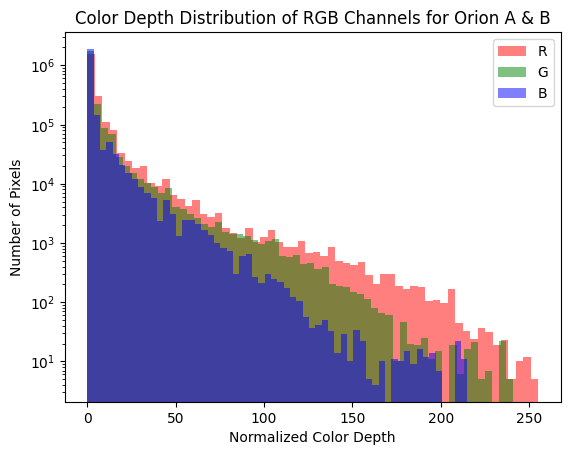

In [179]:
#Create histogram and gnomview of color depth of each channel

#Same process as for Cepheus
plt.hist(R_orion.flatten(), bins=60, color='red', alpha=0.5, label='R')
plt.hist(G_orion.flatten(), bins=60, color='green', alpha=0.5, label='G')
plt.hist(B_orion.flatten(), bins=60, color='blue', alpha=0.5, label='B')
plt.yscale('log')
plt.xlabel('Normalized Color Depth')
plt.ylabel('Number of Pixels')
plt.title('Color Depth Distribution of RGB Channels for Orion A & B')
plt.legend(loc='upper right')
plt.savefig("/fs/lustre/cita/molinaca/Images/Orion/orion_rgb_hist_scaled.png")
plt.show()

hp.gnomview(R_array[d_orionB], rot=[l_orionB, b_orionB], title='Orion A & B in R Color Channel', xsize=1500, ysize=1500, nest=True, unit=r'Color Depth', notext=True)
plt.savefig("/fs/lustre/cita/molinaca/Images/Orion/orion_R.png")
plt.close()
hp.gnomview(G_array[d_orionB], rot=[l_orionB, b_orionB], title='Orion A & B in G Color Channel', xsize=1500, ysize=1500, nest=True, unit=r'Color Depth', notext=True)
plt.savefig('/fs/lustre/cita/molinaca/Images/Orion/orion_G.png')
plt.close()
hp.gnomview(B_array[d_orionB], rot=[l_orionB, b_orionB], title='Orion A & B in B Color Channel', xsize=1500, ysize=1500, nest=True, unit=r'Color Depth', notext=True)
plt.savefig('/fs/lustre/cita/molinaca/Images/Orion/orion_B.png')
plt.close()

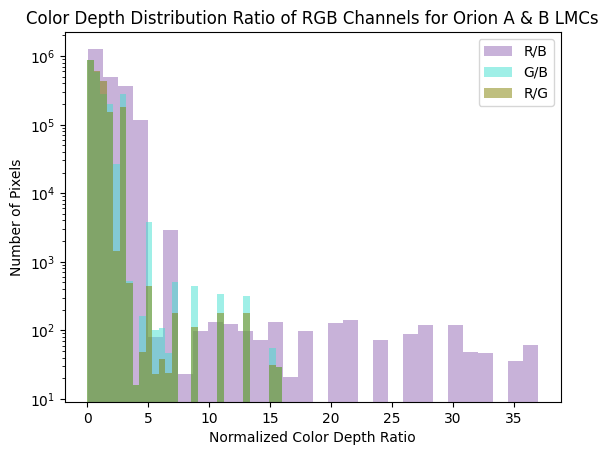

In [180]:
#Calculate histogram rations
orion_ratio_RB = np.divide(R_orion.flatten(), B_orion.flatten(), where=B_orion.flatten()!=0)
plt.hist(orion_ratio_RB, bins=30, color='indigo',alpha=0.3, label='R/B')

orion_ratio_GB = np.divide(G_orion.flatten(), B_orion.flatten(), where=B_orion.flatten()!=0)
plt.hist(orion_ratio_GB, bins=30, color='turquoise', alpha=0.5, label='G/B')

orion_ratio_RG = np.divide(R_orion.flatten(), G_orion.flatten(), where=G_orion.flatten()!=0)
plt.hist(orion_ratio_RG, bins=30, color='olive', alpha=0.5, label='R/G')

plt.yscale('log')
plt.xlabel('Normalized Color Depth Ratio')
plt.ylabel('Number of Pixels')
plt.title('Color Depth Distribution Ratio of RGB Channels for Orion A & B LMCs')
plt.legend()
plt.savefig("/fs/lustre/cita/molinaca/Images/Orion/orion_rgb_hist_ratios.png")
plt.show()


In [181]:
#Create plot for orion panel
hp.gnomview(Ts[:,d_orionB], rot=[l_orionB, b_orionB], xsize=1500, ysize=1500,title='$T$ of Orion A & B with nside 32', nest=True,min=10,max=25, unit='K', notext=True)
plt.savefig('/fs/lustre/cita/molinaca/Images/Orion/orion_T_og.png')
plt.close()

hp.gnomview(Ts_new[d_orionB], rot=[l_orionB, b_orionB], xsize=1500, ysize=1500,title='$T$ of Orion A & B with nside 1024', nest=True,min=10,max=25, unit='K', notext=True)
plt.savefig('/fs/lustre/cita/molinaca/Images/Orion/orion_T_new.png')
plt.close()

hp.gnomview(dEBV[d_orionB], rot=[l_orionB, b_orionB], xsize=1500, ysize=1500,title='$E(B-V)$ of Orion A & B', nest=True, max=1, notext=True)
plt.savefig('/fs/lustre/cita/molinaca/Images/Orion/orion_dEBV.png')
plt.close()

for f_index in range(3):
    
    hp.gnomview(planck_maps[f_index, d_orionB], rot=[l_orionB, b_orionB], xsize=2000, ysize=2000,title=f'Temperature Emission $B$ of Orion A & B at {int(freq_ghz[f_index])} GHz', nest=True,min=1e-17, max=2e-15, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$', notext=True)
    plt.savefig(f"/fs/lustre/cita/molinaca/Images/Orion/orion_planck_{int(freq_ghz[f_index])}.png")
    plt.close()
    hp.gnomview(dens_temp_norm[f_index,d_orionB], rot=[l_orionB, b_orionB], xsize=2000, ysize=2000,title=f'Normalized $B$ and $E(B-V)$ of Orion A & B at {int(freq_ghz[f_index])} GHz', nest=True, min = 0, max = 0.2, unit=r'$\mathrm{W/M^{2}\cdot sr \cdot Hz}$', notext=True)
    plt.savefig(f"/fs/lustre/cita/molinaca/Images/Orion/orion_dxT_norm_{int(freq_ghz[f_index])}.png")
    plt.close()



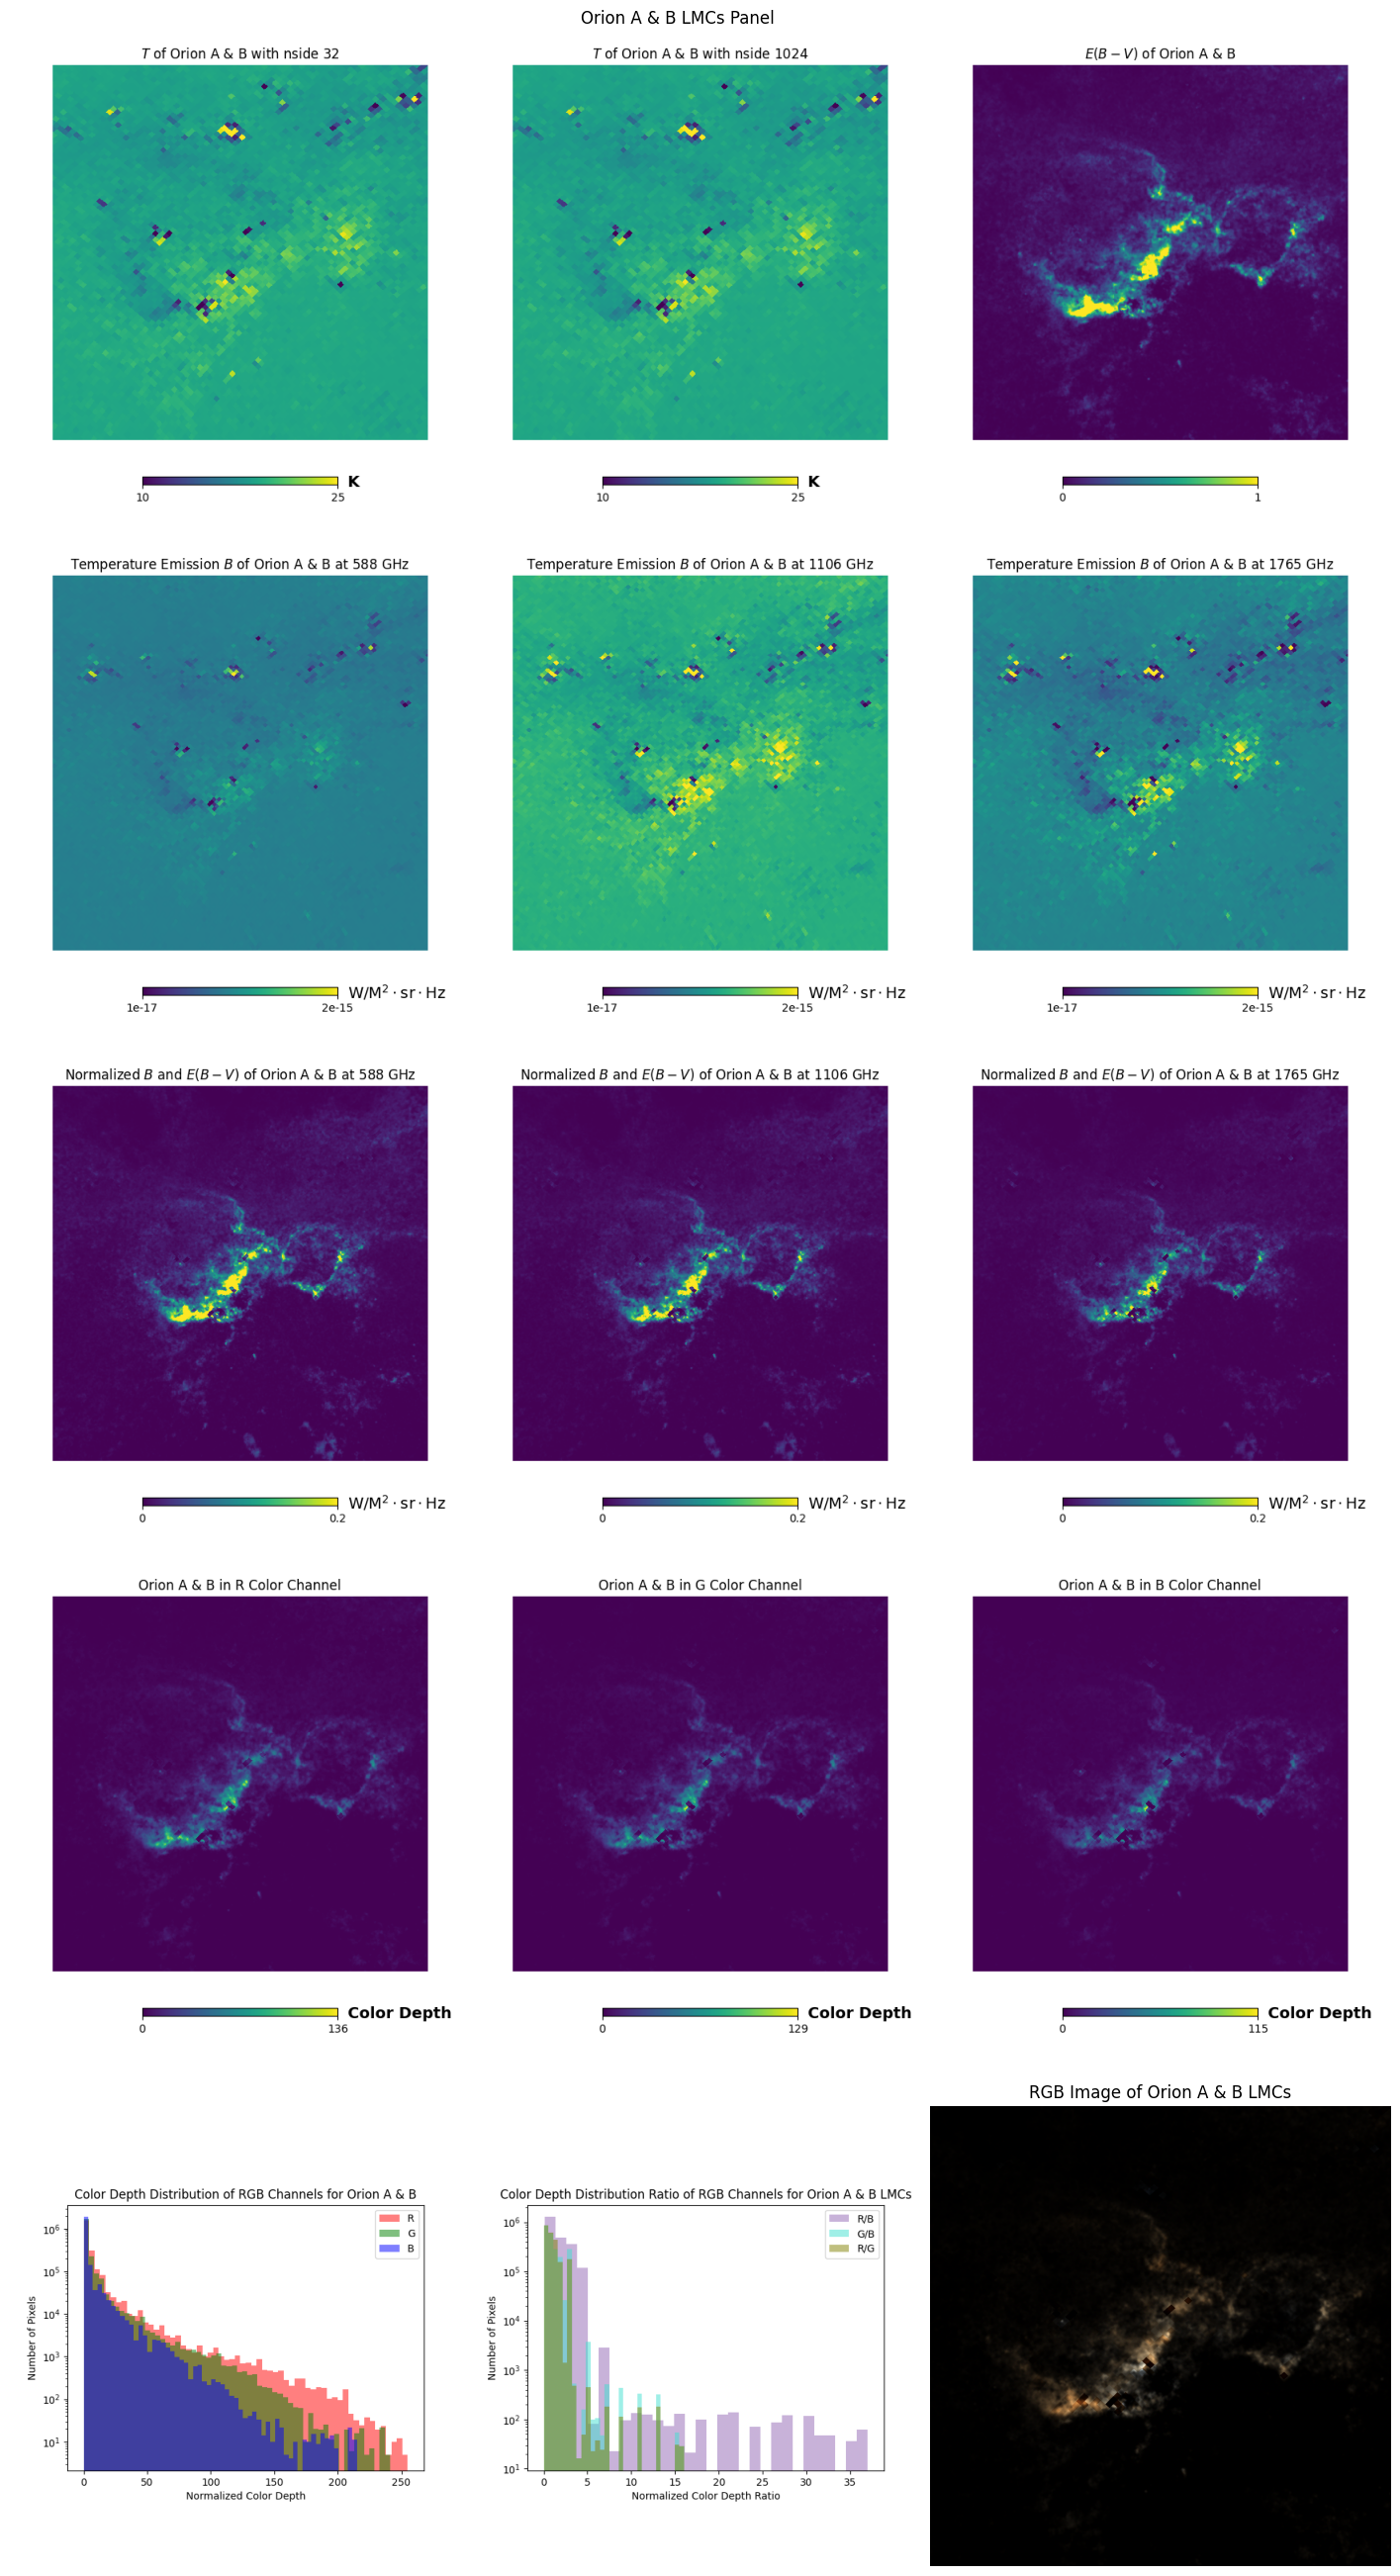

In [182]:
#Creating panel for Orion images

orion_panel = plt.figure(figsize=(18, 30))
gs = gridspec.GridSpec(5, 3, orion_panel)

#Get image paths and names to not repeat code
orion_img_path = "/fs/lustre/cita/molinaca/Images/Orion/orion_"
orion_img_names = ['T_og', 'T_new', 'dEBV', 'planck_588', 'planck_1106', 'planck_1765', 'dxT_norm_588', 'dxT_norm_1106', 'dxT_norm_1765', 'R', 'G', 'B', 'rgb_hist_scaled', 'rgb_hist_ratios', 'rgb_scaled']

for i in range(5):  # Assuming 5 rows
    for j in range(3):  # Assuming 3 columns
        orion_panel.add_subplot(gs[i, j])
        img_index = i * 3 + j  # Calculate index based on grid position
        img = Image.open(orion_img_path + orion_img_names[img_index] + '.png')
        if img_index < len(orion_img_names):
            plt.imshow(img)
        plt.axis('off')  # Turn off axis

        if orion_img_names[img_index] == 'rgb_scaled':
            plt.title('RGB Image of Orion A & B LMCs')

plt.subplots_adjust(wspace=0, hspace=0, top=0.97)
plt.suptitle('Orion A & B LMCs Panel')

plt.savefig('/fs/lustre/cita/molinaca/Images/Orion/orion_panel.png', facecolor='white', edgecolor='none')

plt.show()

### Creating RGB Image of Whole Sky

In [21]:
#Trying to create images for whole sky

directory = 'RGB_images'

R_allsky = np.zeros((model_nslices, pixels))
G_allsky = np.zeros((model_nslices, pixels))
B_allsky = np.zeros((model_nslices, pixels))

target_size = (2000, 1000) 

# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)

for ds_index in range(model_nslices):

    R_allsky[ds_index] = R_array[ds_index]
    G_allsky[ds_index] = G_array[ds_index]
    B_allsky[ds_index] = B_array[ds_index]

    #Now make 2d for image purposes
    R_array_2d = hp.mollview(R_array[ds_index],nest=True, return_projected_map=True, title="R Channel", cbar=False)
    plt.close()  
    G_array_2d = hp.mollview(G_array[ds_index],nest=True, return_projected_map=True, title="G Channel", cbar=False)
    plt.close()  
    B_array_2d = hp.mollview(B_array[ds_index],nest=True, return_projected_map=True, title="B Channel", cbar=False)
    plt.close()  

    R_image = Image.fromarray(np.array(R_array_2d.astype(np.uint8)))
    G_image = Image.fromarray(np.array(G_array_2d.astype(np.uint8)))
    B_image = Image.fromarray(np.array(B_array_2d.astype(np.uint8)))

    RGB_image = Image.merge("RGB", (R_image, G_image, B_image))

    RGB_image = ImageOps.fit(RGB_image, target_size, method=Image.Resampling.LANCZOS)

    RGB_image = RGB_image.transpose(Image.FLIP_TOP_BOTTOM)

    RGB_image.save(f'{directory}/output_image_{ds_index}.png')


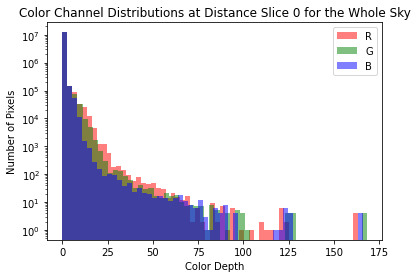

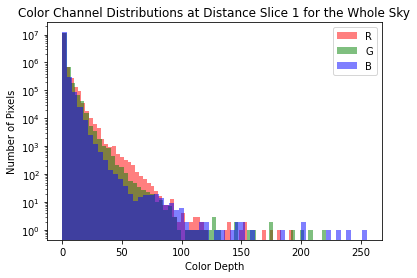

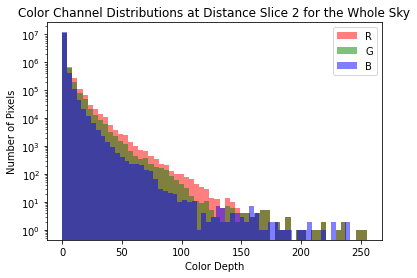

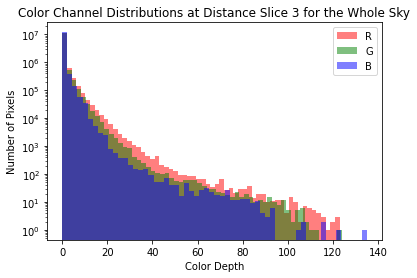

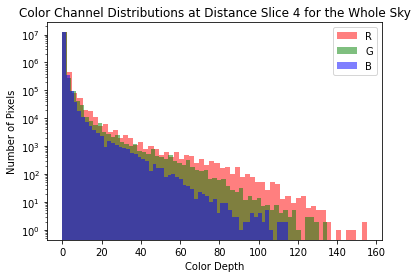

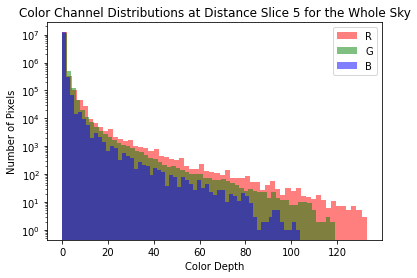

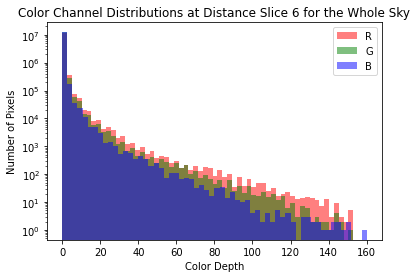

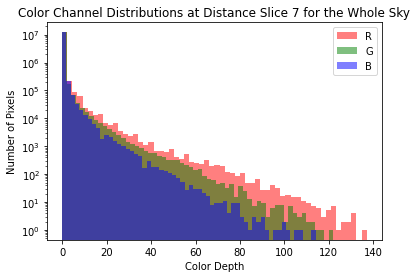

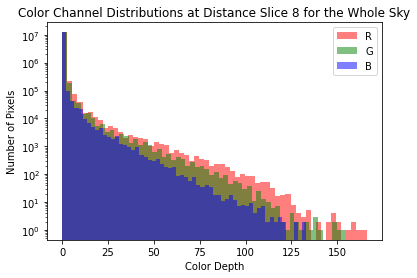

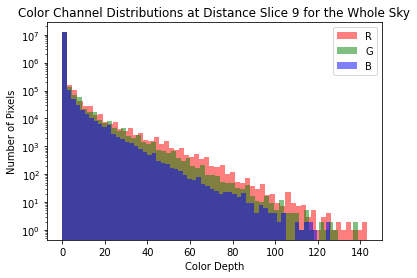

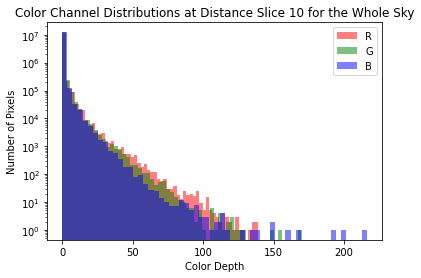

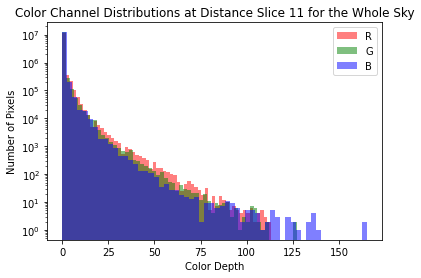

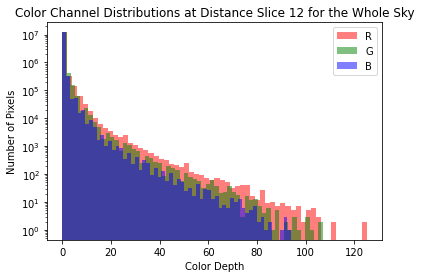

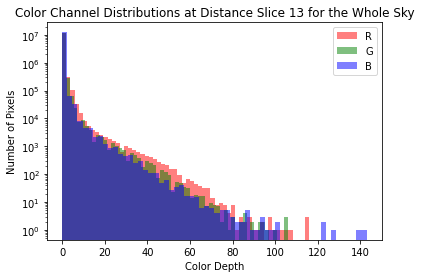

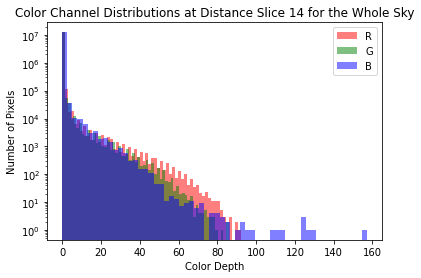

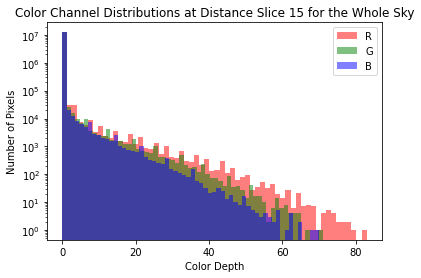

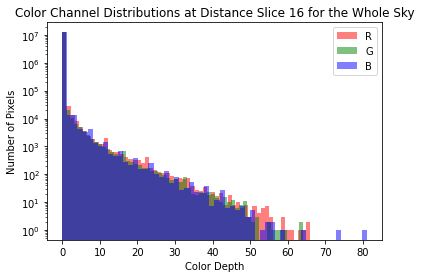

In [22]:
#Plotting Histograms of Color Channels for the Whole Sky
for ds_index in range(model_nslices):

    plt.hist(R_allsky[ds_index].flatten(), bins=60, color='red', alpha=0.5, label='R')
    plt.hist(G_allsky[ds_index].flatten(), bins=60, color='green', alpha=0.5, label='G')
    plt.hist(B_allsky[ds_index].flatten(), bins=60, color='blue', alpha=0.5, label='B')
    plt.xlabel('Color Depth')
    plt.ylabel('Number of Pixels')
    plt.title(f'Color Channel Distributions at Distance Slice {ds_index} for the Whole Sky')
    plt.legend(loc='upper right')
    plt.yscale('log')
    plt.show()


In [183]:
#Making hp.mollview plots of each color channel for the whole sky
# for ds_index in range(model_nslices):
#     hp.mollview(R_allsky[ds_index], title="R Channel at Distance Slice "+str(ds_index), nest=True)
#     hp.mollview(G_allsky[ds_index], title="G Channel at Distance Slice "+str(ds_index), nest=True)
#     hp.mollview(B_allsky[ds_index], title="B Channel at Distance Slice "+str(ds_index), nest=True)

In [ ]:
#plot_3D_temperature_slice_maps(data_dict)